In [72]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [73]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds'

# set colorblind theme for plots:
sns.set_theme(context='notebook', style="ticks", palette='colorblind')
sns.set_color_codes(palette='colorblind')

# set path as working directory:
os.chdir(path)

In [74]:
# load data on mergers and acquisitions:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

# rename the columns:
transformations = transformations.rename(columns={'#ID_RSSD_PREDECESSOR': 'Predecessor ID', 
                                                  'ID_RSSD_SUCCESSOR': 'Successor ID',
                                                 'DT_TRANS': 'Transaction Date',
                                                 'TRNSFM_CD': 'Transaction Code',})

# convert the 'transaction_date' to datetime format:
transformations['Transaction Date'] = pd.to_datetime(transformations['Transaction Date'], format='%Y%m%d')
transformations = transformations[['Predecessor ID', 'Successor ID', 'Transaction Date', 'Transaction Code']]

In [75]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'CPIAUCSL_NBD19840101': 'CPI',
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'].astype(float)
aggregates['CPI'] = aggregates['CPI'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['CPI'] * 100

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

In [76]:
# compute the growth rate of Nominal GDP and the Deflator:
aggregates['Growth Rate Nominal GDP'] = aggregates['Nominal GDP'].pct_change(fill_method=None)
aggregates['Growth Rate Deflator'] = aggregates['Deflator'].pct_change(fill_method=None)
aggregates['Growth Rate CPI'] = aggregates['CPI'].pct_change(fill_method=None)

# compute the growth rate of Real GDP by subtracting the growth rate of the Deflator from the growth rate of Nominal GDP:
aggregates['Growth Rate Real GDP'] = aggregates['Growth Rate Nominal GDP'] - aggregates['Growth Rate Deflator']

In [77]:
securities = pd.read_csv('securities_balanced_panel.csv', low_memory=False)
securities['Date'] = pd.to_datetime(securities['Date'], format='%Y-%m-%d')

In [78]:
treasuries = pd.read_csv('treasuries_balanced_panel.csv', low_memory=False)
treasuries['Date'] = pd.to_datetime(treasuries['Date'], format='%Y-%m-%d')

In [79]:
# load call reports data:
loans = pd.read_csv('loans_balanced_panel.csv', low_memory=False)
int_income = pd.read_csv('interest_income_balanced.csv', low_memory=False)
deposits = pd.read_csv('deposits_balanced_panel.csv', low_memory=False)

# drop duplicates from 'deposits':
deposits = deposits.drop_duplicates()

# merge the datasets
df = pd.merge(loans[['Date', 'IDRSSD', 'RCON2122', 'Flag']], deposits, 
              on=['IDRSSD', 'Date'], how='outer', suffixes=('_RCON', '_RIAD'))

# adjust the dates
df['Date'] = pd.to_datetime(df['Date'])

# create a 'Flag' that is zero if both are zero, and 1 if either is 1:
df['Flag'] = np.where(df['Flag_RCON'] + df['Flag_RIAD'] > 0, 1, 0)

# drop the two flag columns:
df = df.drop(columns=['Flag_RCON', 'Flag_RIAD'])

# drop the RSSDID of banks with Flag = 1:
banks_flag = df[df['Flag']==1]['IDRSSD'].unique()
df = df[~df['IDRSSD'].isin(banks_flag)]

In [80]:
# merge 'df' and 'securities':
df = pd.merge(df, securities, on=['IDRSSD', 'Date'], how='inner')
df = pd.merge(df, treasuries, on=['IDRSSD', 'Date'], how='inner')
#df = df[df['Total Securities']>0]


In [81]:
#df[df['Total Securities']>0].groupby('IDRSSD')['IDRSSD'].value_counts().unique

In [82]:
main_panel = df[['IDRSSD', 'Date', 'RCON2122', 'RCON2200', 'Total Securities', 'Treasuries']].copy()
main_panel.rename(columns = {'RCON2122': 'Loans', 'RCON2200': 'Deposits'}, inplace = True)

In [83]:
main_panel.sort_values(by=['IDRSSD', 'Date'], inplace=True)

In [84]:
main_panel[(main_panel['IDRSSD']==37) & (main_panel['Date'].dt.year>2004) & (main_panel['Date'].dt.year<2014)]

,IDRSSD,Date,Loans,Deposits,Total Securities,Treasuries
16,37,2005-03-31,44341.0,65568.0,28927.0,500.0
17,37,2005-06-30,46555.0,64785.0,28010.0,500.0
18,37,2005-09-30,47307.0,67629.0,26561.0,500.0
19,37,2005-12-31,43717.0,65422.0,26911.0,0.0
20,37,2006-03-31,45198.0,66492.0,27870.0,0.0
21,37,2006-06-30,47886.0,65095.0,27850.0,0.0
22,37,2006-09-30,46573.0,64387.0,27631.0,0.0
23,37,2006-12-31,45043.0,64405.0,27738.0,0.0
24,37,2007-03-31,45008.0,63966.0,28474.0,0.0
25,37,2007-06-30,46533.0,63634.0,26977.0,0.0


In [85]:
main_panel['Treasuries Growth'] = main_panel.groupby('IDRSSD')['Treasuries'].pct_change(fill_method=None)
print(main_panel['Treasuries Growth'].describe())
# fill 'inf' with NaN:
main_panel['Treasuries Growth'] = main_panel['Treasuries Growth'].replace([np.inf, -np.inf], np.nan)
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
main_panel['Treasuries Growth'] = main_panel['Treasuries Growth'].mask((main_panel['Treasuries Growth'] < main_panel['Treasuries Growth'].quantile(0.01)) | (main_panel['Treasuries Growth'] > main_panel['Treasuries Growth'].quantile(0.99)))
print(main_panel['Treasuries Growth'].describe())

count    5.482000e+04
mean              inf
std               NaN
min     -1.000000e+00
25%     -8.628013e-03
50%      0.000000e+00
75%      4.081633e-03
max               inf
Name: Treasuries Growth, dtype: float64
count    51033.000000
mean        -0.019969
std          0.449457
min         -1.000000
25%         -0.036990
50%          0.000000
75%          0.001516
max          3.503476
Name: Treasuries Growth, dtype: float64


C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [86]:
main_panel['Securities Growth'] = main_panel.groupby('IDRSSD')['Total Securities'].pct_change(fill_method=None)
print(main_panel['Securities Growth'].describe())
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
main_panel['Securities Growth'] = main_panel['Securities Growth'].mask((main_panel['Securities Growth'] < main_panel['Securities Growth'].quantile(0.01)) | (main_panel['Securities Growth'] > main_panel['Securities Growth'].quantile(0.99)))
print(main_panel['Securities Growth'].describe())

count    1.883470e+05
mean              inf
std               NaN
min     -1.000000e+00
25%     -3.957404e-02
50%     -1.205255e-03
75%      5.453740e-02
max               inf
Name: Securities Growth, dtype: float64
count    184579.000000
mean          0.016282
std           0.110718
min          -0.309768
25%          -0.038559
50%          -0.001205
75%           0.052761
max           0.681758
Name: Securities Growth, dtype: float64


C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


## Time Series 

In [87]:
df.columns

Index(['Date', 'IDRSSD', 'RCON2122', 'Financial Institution Name',
       'RCON2200_legacy', 'RCON2200_new', 'Difference', 'RCON2200', 'Flag',
       'Total Securities', 'Treasuries'],
      dtype='object')

In [88]:
# create an 'Agg. Loans' summing all the loans in a given Date:
df['Agg. Loans'] = df.groupby('Date')['RCON2122'].transform('sum')
df['Agg. Deposits'] = df.groupby('Date')['RCON2200'].transform('sum')

# compute aggregate Total Securities, and Treasuries:
df['Agg. Total Securities'] = df.groupby('Date')['Total Securities'].transform('sum')
df['Agg. Treasuries'] = df.groupby('Date')['Treasuries'].transform('sum')

In [89]:
# merge df with aggregates:
df = pd.merge(df[['Date', 'IDRSSD', 'Agg. Loans', 'Agg. Total Securities', 'Agg. Treasuries',
                  'Agg. Deposits', 'Flag']], aggregates[['Date', 'FEDFUNDS', 'Real GDP', 'Deflator', 'CPI']], on='Date', how='left')

# create aggregate real loans and deposits:
df['Agg. Real Loans'] = df['Agg. Loans'] / df['CPI'] *100
df['Agg. Real Deposits'] = df['Agg. Deposits'] / df['CPI'] *100

In [90]:
df = df[['Date', 'Agg. Real Loans', 'Agg. Real Deposits', 'Agg. Total Securities','Agg. Treasuries', 'FEDFUNDS', 'Real GDP', 'CPI']]

# remove duplicates:
df = df.drop_duplicates()

In [91]:
HP = 1
param = 1600

if HP == 1:

    # De-trend the variables using an HP filter:
    df['De-trended Real Loans'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Loans']), lamb=param)[0]
    df['De-trended Real GDP'] = sm.tsa.filters.hpfilter(np.log(df['Real GDP']), lamb=param)[0]
    df['De-trended Real Deposits'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Deposits']), lamb=param)[0]

else:
    # create a 'Time' variable grouping 'Dates':
    df['Time'] = df.groupby('Date').ngroup()

    # run regressions to detrend variables of interest 
    df['De-trended Real Loans'] = sm.OLS(np.log(df['Agg. Real Loans']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real Deposits'] = sm.OLS(np.log(df['Agg. Real Deposits']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real GDP'] = sm.OLS(np.log(df['Real GDP']), sm.add_constant(df['Time'])).fit().resid

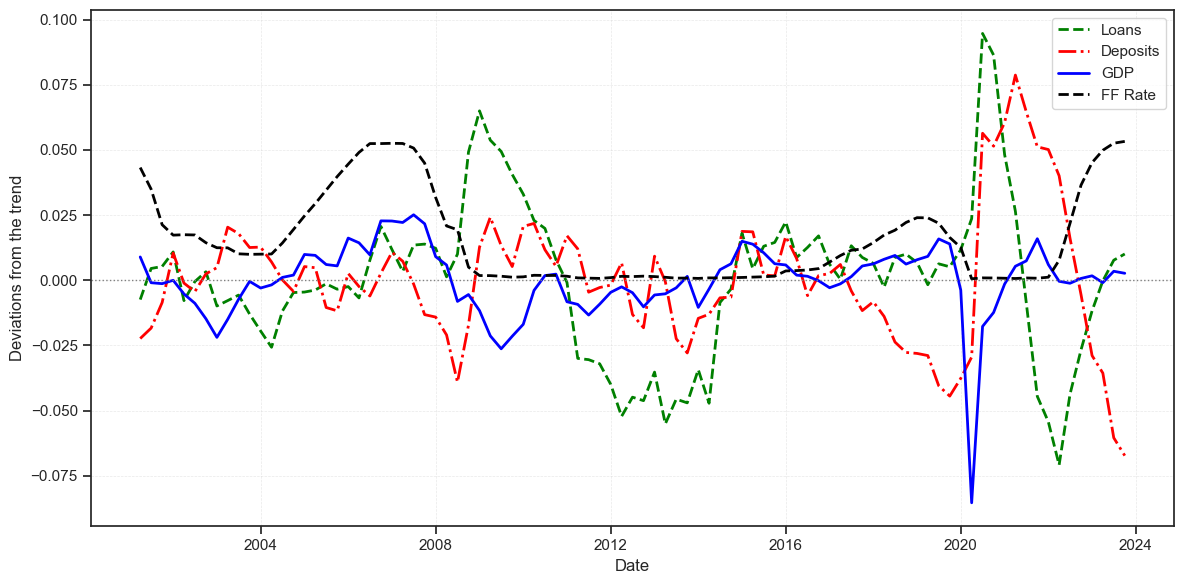

In [92]:
# plot the de-trended loans using seaborn:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='De-trended Real Loans', data=df, linewidth=2, label='Loans', color='green', linestyle='--')
sns.lineplot(x='Date', y='De-trended Real Deposits', data=df, linewidth=2, label='Deposits', color='red', linestyle='-.')
sns.lineplot(x='Date', y='De-trended Real GDP', data=df, linewidth=2, label='GDP', color='blue')
sns.lineplot(x='Date', y='FEDFUNDS', data=df, linewidth=2, label='FF Rate', color='black', linestyle='--')
# add a line at zero:
plt.axhline(y=0, color='grey', linestyle=':', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Deviations from the trend')
plt.legend()
#plt.ylim(-0.1, 0.15)
plt.tight_layout()
# add the grids:
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [93]:
# print the correlation matrix, specifying the entries:
corr = df[['De-trended Real Loans', 'De-trended Real Deposits', 'De-trended Real GDP', 'FEDFUNDS']].corr()
print(corr)

                          De-trended Real Loans  De-trended Real Deposits  \
De-trended Real Loans                  1.000000                  0.149497   
De-trended Real Deposits               0.149497                  1.000000   
De-trended Real GDP                   -0.131675                 -0.034771   
FEDFUNDS                               0.044755                 -0.433214   

                          De-trended Real GDP  FEDFUNDS  
De-trended Real Loans               -0.131675  0.044755  
De-trended Real Deposits            -0.034771 -0.433214  
De-trended Real GDP                  1.000000  0.467552  
FEDFUNDS                             0.467552  1.000000  


In [94]:
# create 'Inflation' as the growth rate of the CPI:
df['Inflation'] = df['CPI'].pct_change(fill_method=None)

# create a variable named 'High Inflation' as 1 if the inflation is above the average, and 0 otherwise:
df['High Inflation'] = 0
df.loc[df['Inflation'] > df['Inflation'].mean(), 'High Inflation'] = 1

In [95]:
# create a variable named 'FF Hike' as 1 if the FF rate increased, and 0 otherwise:
df['FF Hike'] = 0
df.loc[df['FEDFUNDS'] > df['FEDFUNDS'].shift(1), 'FF Hike'] = 1

In [96]:
# create a variable named 'Boom' that is 1, if the De-trended Real GDP is above 0, and 0 otherwise:
df['Recession'] = 0
df.loc[df['De-trended Real GDP'] < 0, 'Recession'] = 1

In [97]:
# count how many 'FF Hike' are there in the dataset from 2001 onwards:
year = 2001

print(f'FF Hikes from {year} onwards:                           ',
      df[df['Date'].dt.year > year]['FF Hike'].sum())
# count the 'FF Hikes associated with 'High Inflation':
print('FF Hikes associated with High Inflation:              ', 
      df[(df['Date'].dt.year > year) & (df['High Inflation'] == 1)]['FF Hike'].sum())
# count the 'FF Hikes' associated with 'High Inflation' and 'Boom':
print('FF Hikes associated with High Inflation and Recession:', 
      df[(df['Date'].dt.year > year) & (df['High Inflation'] == 1) & (df['Recession'] == 1)]['FF Hike'].sum())
print('FF Hikes associated with High Inflation and boom:     ', 
      df[(df['Date'].dt.year > year) & (df['High Inflation'] == 1) & (df['Recession'] == 0)]['FF Hike'].sum())


FF Hikes from 2001 onwards:                            48
FF Hikes associated with High Inflation:               28
FF Hikes associated with High Inflation and Recession: 10
FF Hikes associated with High Inflation and boom:      18


In [98]:
# print the correlation between FF rate and loans for the recession and non-recession periods:
print('Deposits:')
print('Correlation between FF rates and deposits in recessions:      ', df[df['Recession']==1]['FEDFUNDS'].corr(df[df['Recession']==1]['De-trended Real Deposits']))
print('Correlation between FF rates and deposits in booms:           ', df[df['Recession']==0]['FEDFUNDS'].corr(df[df['Recession']==0]['De-trended Real Deposits']))
print('')
print('Loans:')
print('Correlation between FF rates and loans in recessions:         ', df[df['Recession']==1]['FEDFUNDS'].corr(df[df['Recession']==1]['De-trended Real Loans']))
print('Correlation between FF rates and loans in booms:              ', df[df['Recession']==0]['FEDFUNDS'].corr(df[df['Recession']==0]['De-trended Real Loans']))

Deposits:
Correlation between FF rates and deposits in recessions:       -0.36249003959296455
Correlation between FF rates and deposits in booms:            -0.44295406154671635

Loans:
Correlation between FF rates and loans in recessions:          -0.04925726533508737
Correlation between FF rates and loans in booms:               0.12062691289194764


In [99]:
# print the correlation between FF rate and loans for the recession and non-recession periods:
print('Deposits:')
print('Correlation between FF rates and deposits in recessions:      ', df[(df['Recession']==1) & (df['High Inflation']==1) ]['FEDFUNDS'].corr(df[(df['Recession']==1) & (df['High Inflation']==1) ]['De-trended Real Deposits']))
print('Correlation between FF rates and deposits in booms:           ', df[(df['Recession']==0) & (df['High Inflation']==1) ]['FEDFUNDS'].corr(df[(df['Recession']==0) & (df['High Inflation']==1) ]['De-trended Real Deposits']))
print('')
print('Loans:')
print('Correlation between FF rates and loans in recessions:         ', df[(df['Recession']==1) & (df['High Inflation']==1) ]['FEDFUNDS'].corr(df[(df['Recession']==1) & (df['High Inflation']==1) ]['De-trended Real Loans']))
print('Correlation between FF rates and loans in booms:              ', df[(df['Recession']==0) & (df['High Inflation']==1) ]['FEDFUNDS'].corr(df[(df['Recession']==0) & (df['High Inflation']==1) ]['De-trended Real Loans']))

Deposits:
Correlation between FF rates and deposits in recessions:       -0.49752752071773365
Correlation between FF rates and deposits in booms:            -0.5887562731701216

Loans:
Correlation between FF rates and loans in recessions:          -0.20532651825339243
Correlation between FF rates and loans in booms:               0.27076881251069357


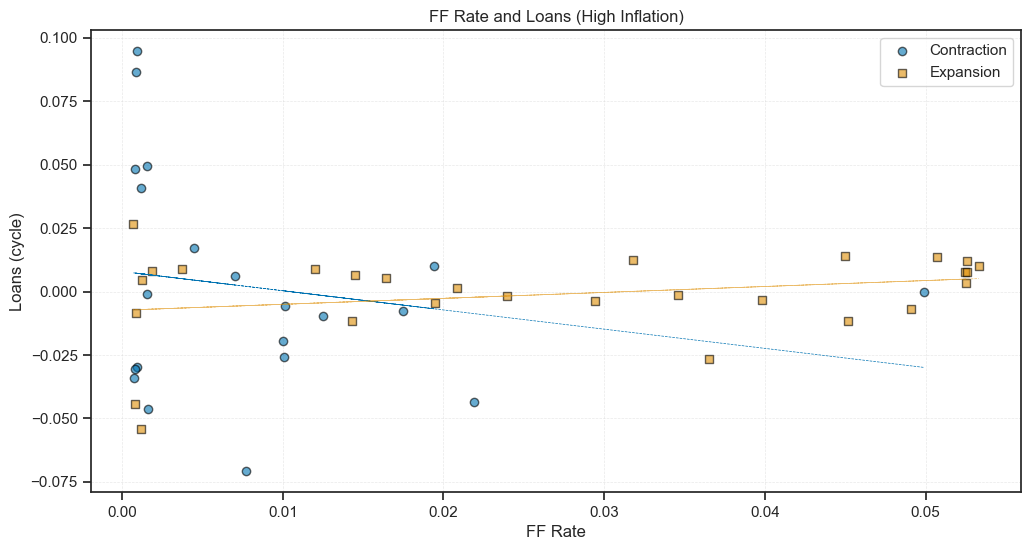

In [100]:
# make a scatter plot of the FF rate and loans for the recession and non-recession periods, using plt.scatter:
plt.figure(figsize=(12, 6))
plt.scatter(df[(df['Recession']==1) & (df['High Inflation']==1) 
               ]['FEDFUNDS'], 
               df[(df['Recession']==1) & (df['High Inflation']==1) 
               ]['De-trended Real Loans'], 
               label='Contraction', edgecolors='black', alpha=0.6)
# add a regression line:
x = df[(df['Recession']==1) & (df['High Inflation']==1) ]['FEDFUNDS']
y = df[(df['Recession']==1) & (df['High Inflation']==1) ]['De-trended Real Loans']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, linestyle='--', linewidth=0.5)
plt.scatter(df[(df['Recession']==0) & (df['High Inflation']==1) ]['FEDFUNDS'], 
               df[(df['Recession']==0) & (df['High Inflation']==1) ]['De-trended Real Loans'],
               label='Expansion', edgecolors='black', marker='s', alpha=0.6)
# add a regression line:
x = df[(df['Recession']==0) & (df['High Inflation']==1) ]['FEDFUNDS']
y = df[(df['Recession']==0) & (df['High Inflation']==1) ]['De-trended Real Loans']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, linestyle='--', linewidth=0.5, alpha=0.6)
plt.title('FF Rate and Loans (High Inflation)')
plt.xlabel('FF Rate')
plt.ylabel('Loans (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('FF_Rate_Loans.png')
plt.show()


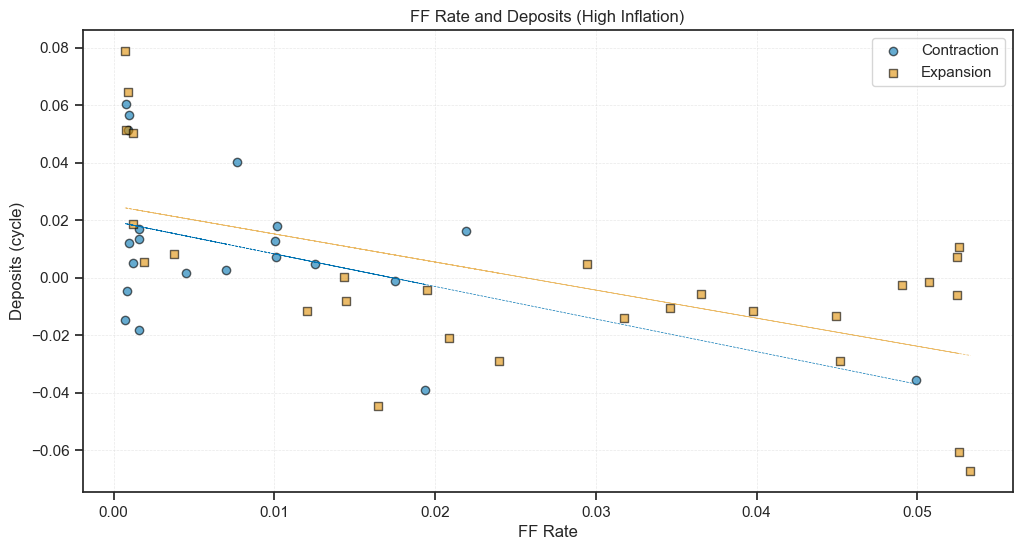

In [101]:
# make the same plot as above with 'Deposits' instead of 'Loans':
plt.figure(figsize=(12, 6))
plt.scatter(df[(df['Recession']==1) & (df['High Inflation']==1)]['FEDFUNDS'], 
            df[(df['Recession']==1) & (df['High Inflation']==1)]['De-trended Real Deposits'], 
            label='Contraction', edgecolors='black', alpha=0.6)
# add a regression line:
x = df[(df['Recession']==1) & (df['High Inflation']==1)]['FEDFUNDS']
y = df[(df['Recession']==1) & (df['High Inflation']==1)]['De-trended Real Deposits']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, linestyle='--', linewidth=0.5)
plt.scatter(df[(df['Recession']==0) & (df['High Inflation']==1)]['FEDFUNDS'], 
            df[(df['Recession']==0) & (df['High Inflation']==1)]['De-trended Real Deposits'], 
            label='Expansion', edgecolors='black', marker='s', alpha=0.6)
# add a regression line:
x = df[(df['Recession']==0) & (df['High Inflation']==1)]['FEDFUNDS']
y = df[(df['Recession']==0) & (df['High Inflation']==1)]['De-trended Real Deposits']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, linestyle='--', linewidth=0.5, alpha=0.6)
plt.title('FF Rate and Deposits (High Inflation)')
plt.xlabel('FF Rate')
plt.ylabel('Deposits (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('FF_Rate_Deposits.png')
plt.show()

In [102]:
main_agg = df.copy()

#### Bank Index

In [103]:
# read the 'bank index' data:
bank_index = pd.read_excel('bank index.xlsx')
bank_index['Date'] = pd.to_datetime(bank_index['Date'])
df = pd.merge(df, bank_index, on='Date', how='right')
df.rename(columns = {'Last Price':'Bank Index'}, inplace = True)

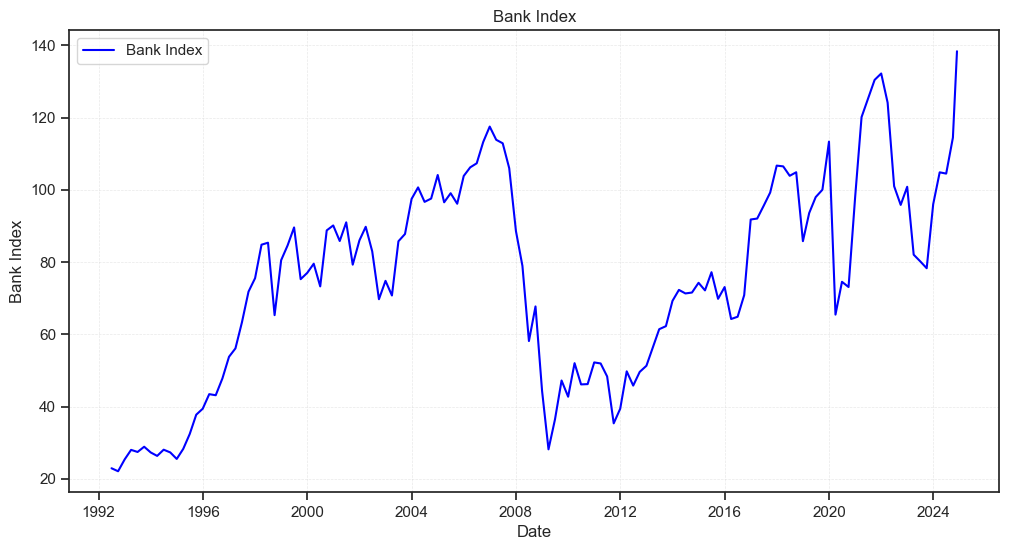

In [104]:
# plot the bank index:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Bank Index'], label='Bank Index', color='blue')
plt.title('Bank Index')
plt.xlabel('Date')
plt.ylabel('Bank Index')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')


In [105]:
# de-trend the bank index using an HP filter:
df['De-trended Bank Index'] = sm.tsa.filters.hpfilter(np.log(df['Bank Index']), lamb=param)[0]

# create the growth rate of the bank index:
df['Growth Rate Bank Index'] = df['Bank Index'].pct_change(fill_method=None)

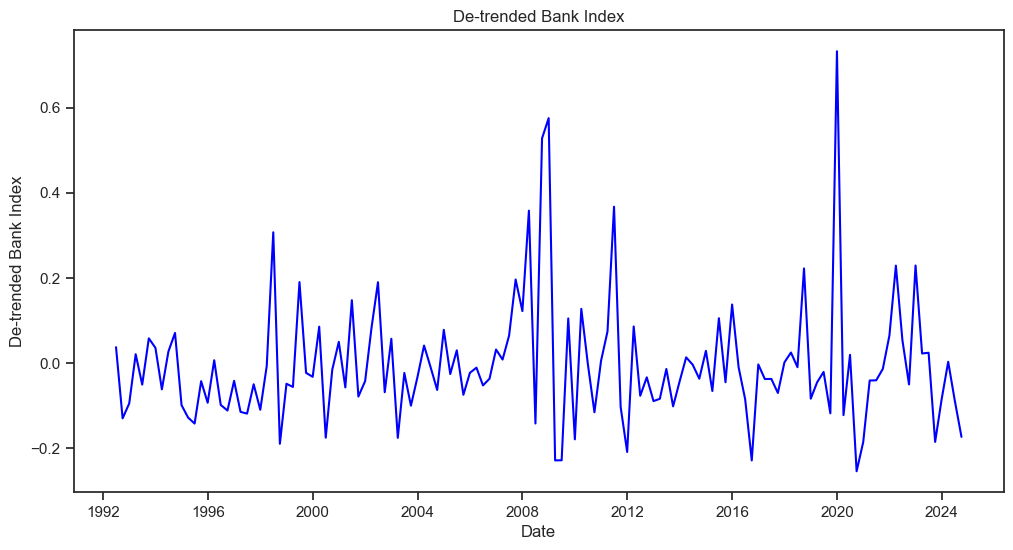

In [106]:
# plot the de-trended bank index:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Growth Rate Bank Index'], label='Bank Index', color='blue')
plt.title('De-trended Bank Index')
plt.xlabel('Date')
plt.ylabel('De-trended Bank Index')
plt.show()

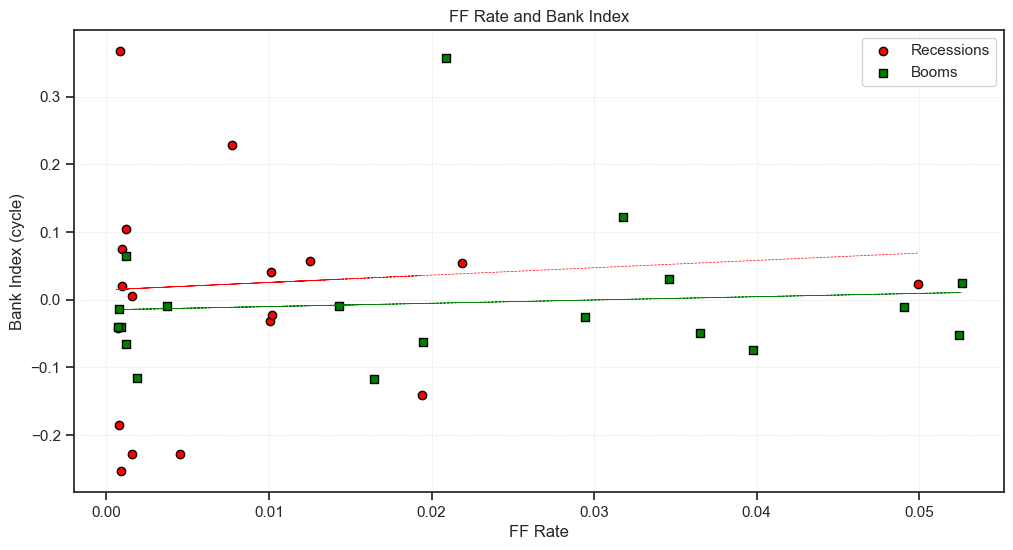

In [107]:
# make the same plot as above with 'Deposits' instead of 'Loans':
plt.figure(figsize=(12, 6))
plt.scatter(df[(df['Recession']==1) & (df['High Inflation']==1)]['FEDFUNDS'], 
            df[(df['Recession']==1) & (df['High Inflation']==1)]['Growth Rate Bank Index'], label='Recessions', color='red', edgecolors='black')
x = df[df['Recession']==1]['FEDFUNDS']
y = df[df['Recession']==1]['Growth Rate Bank Index']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle='--', linewidth=0.5)
plt.scatter(df[(df['Recession']==0) & (df['High Inflation']==1)]['FEDFUNDS'], 
            df[(df['Recession']==0) & (df['High Inflation']==1)]['Growth Rate Bank Index'], label='Booms', color='green', edgecolors='black', marker='s')
x = df[(df['Recession']==0) & (df['High Inflation']==1)]['FEDFUNDS']
y = df[(df['Recession']==0) & (df['High Inflation']==1)]['Growth Rate Bank Index']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='green', linestyle='--', linewidth=0.5)
plt.title('FF Rate and Bank Index')
plt.xlabel('FF Rate')
plt.ylabel('Bank Index (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('FF_Rate_Bank_Index.svg')
plt.show()

In [108]:
# do the above regression using the OLS function from statsmodels:
X = sm.add_constant(df[df['Recession']==1]['FEDFUNDS'])
Y = df[df['Recession']==1]['Growth Rate Bank Index'].dropna()
model = sm.OLS(Y, X).fit()

# print the summary of the regression:
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Growth Rate Bank Index   R-squared:                       0.002
Model:                                OLS   Adj. R-squared:                 -0.031
Method:                     Least Squares   F-statistic:                   0.06079
Date:                    Fri, 20 Dec 2024   Prob (F-statistic):              0.807
Time:                            07:52:10   Log-Likelihood:                 1.1473
No. Observations:                      32   AIC:                             1.705
Df Residuals:                          30   BIC:                             4.637
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

## Panel Data

In [109]:
# merge 'test' and 'main': 
df = pd.merge(main_panel, main_agg, on=['Date'], how='left')

In [110]:
# Create the variable 'Real Loans' and 'Real Deposits':
df['Real Loans'] = df['Loans'] / df['CPI'] * 100
df['Real Deposits'] = df['Deposits'] / df['CPI'] * 100

# create the 'Share Real Loans' and 'Share Real Deposits' per bank and date:
df['Share Real Loans'] = df['Real Loans'] / df['Agg. Real Loans'] *100
df['Share Real Deposits'] = df['Real Deposits'] / df['Agg. Real Deposits'] *100 

In [111]:
#df['Loans Growth'] = df.groupby('IDRSSD')['Loans'].pct_change(fill_method=None)
df['Loans Growth'] = df.groupby('IDRSSD')['Real Loans'].pct_change(fill_method=None)
print(df['Loans Growth'].describe())
# mask top and bottom 1% of the distribution:
df['Loans Growth'] = df['Loans Growth'].mask((df['Loans Growth'] < df['Loans Growth'].quantile(0.01)) | (df['Loans Growth'] > df['Loans Growth'].quantile(0.99)))
print(df['Loans Growth'].describe())

count    189714.000000
mean          0.010727
std           0.112818
min          -0.844948
25%          -0.017108
50%           0.005542
75%           0.029923
max          20.096978
Name: Loans Growth, dtype: float64
count    185918.000000
mean          0.007735
std           0.041411
min          -0.117403
25%          -0.016533
50%           0.005542
75%           0.029329
max           0.194888
Name: Loans Growth, dtype: float64


In [132]:
#df['Deposits Growth'] = df.groupby('IDRSSD')['Deposits'].pct_change(fill_method=None)
df['Deposits Growth'] = df.groupby('IDRSSD')['Real Deposits'].pct_change(fill_method=None)
print(df['Deposits Growth'].describe())
# mask top and bottom 1% of the distribution:
df['Deposits Growth'] = df['Deposits Growth'].mask((df['Deposits Growth'] < df['Deposits Growth'].quantile(0.01)) | (df['Deposits Growth'] > df['Deposits Growth'].quantile(0.99)))
print(df['Deposits Growth'].describe())

count    189720.000000
mean          0.010665
std           0.095821
min          -0.999281
25%          -0.019823
50%           0.003490
75%           0.030254
max          15.878253
Name: Deposits Growth, dtype: float64
count    185924.000000
mean          0.007646
std           0.043093
min          -0.104644
25%          -0.019250
50%           0.003490
75%           0.029555
max           0.203941
Name: Deposits Growth, dtype: float64


In [113]:
drop = df[(df['Real Deposits']==0) | (df['Real Loans']==0)]['IDRSSD'].unique()
df = df[~df['IDRSSD'].isin(drop)]

In [114]:
# compute the de-trended 'Real Loans' and 'Real Deposits' per ID, using an HP filter:
df['De-trended Real Loans'] = df.groupby('IDRSSD')['Real Loans'].transform(lambda x: sm.tsa.filters.hpfilter(np.log(x), lamb=param)[0])
df['De-trended Real Deposits'] = df.groupby('IDRSSD')['Real Deposits'].transform(lambda x: sm.tsa.filters.hpfilter(np.log(x), lamb=param)[0])

In [115]:
# compute the average FEDFUNDS per date, and accross all dates:
df['Average FF Rate'] = df.groupby('Date')['FEDFUNDS'].transform('mean')
df['Average FF Rate'] = df['Average FF Rate'].mean()

print('Avg. FedFunds Rate:',   df['Average FF Rate'].unique()[0])

# create a variable named 'FF Hike' as 1 if the FF rate increased, and 0 otherwise:
df['FF Hike'] = 0
df.loc[df['FEDFUNDS'] > df['FEDFUNDS'].shift(1), 'FF Hike'] = 1

Avg. FedFunds Rate: 0.015478021978021977


In [116]:
# compute inflation as the growth rate of the CPI:
df['Inflation'] = df['CPI'].pct_change(fill_method=None)

# compute the average inflation in the whole sample:
print('The average quarterly inflation in the period was:',  df['Inflation'].mean()*100)

# create a variable named 'High Inflation' as 1 if the inflation is above the average, and 0 otherwise:
df['High Inflation'] = 0
df.loc[df['Inflation'] > df['Inflation'].mean(), 'High Inflation'] = 1

The average quarterly inflation in the period was: 0.14527605754621079


In [117]:
df.columns

Index(['IDRSSD', 'Date', 'Loans', 'Deposits', 'Total Securities', 'Treasuries',
       'Treasuries Growth', 'Securities Growth', 'Agg. Real Loans',
       'Agg. Real Deposits', 'Agg. Total Securities', 'Agg. Treasuries',
       'FEDFUNDS', 'Real GDP', 'CPI', 'De-trended Real Loans',
       'De-trended Real GDP', 'De-trended Real Deposits', 'Inflation',
       'High Inflation', 'FF Hike', 'Recession', 'Real Loans', 'Real Deposits',
       'Share Real Loans', 'Share Real Deposits', 'Loans Growth',
       'Deposits Growth', 'Average FF Rate'],
      dtype='object')

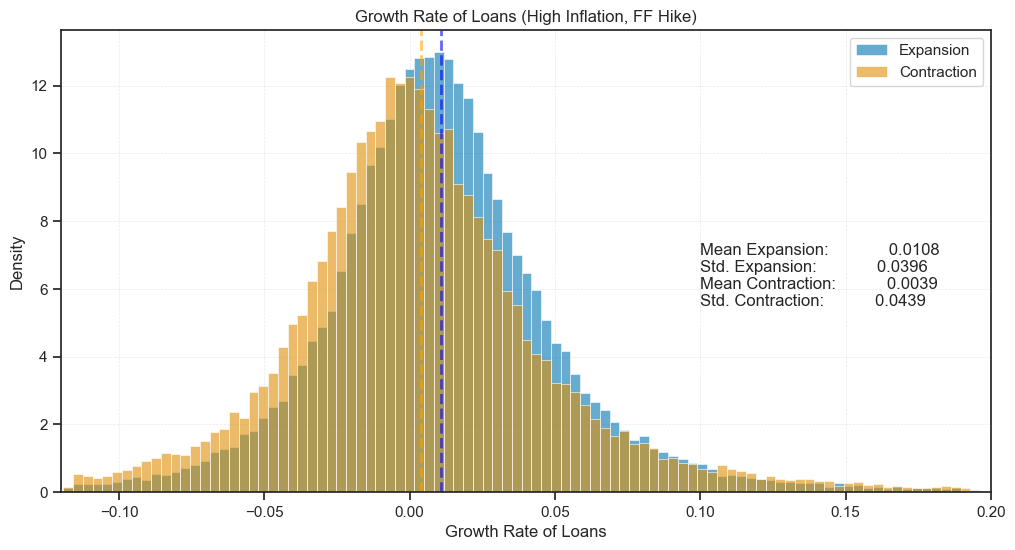

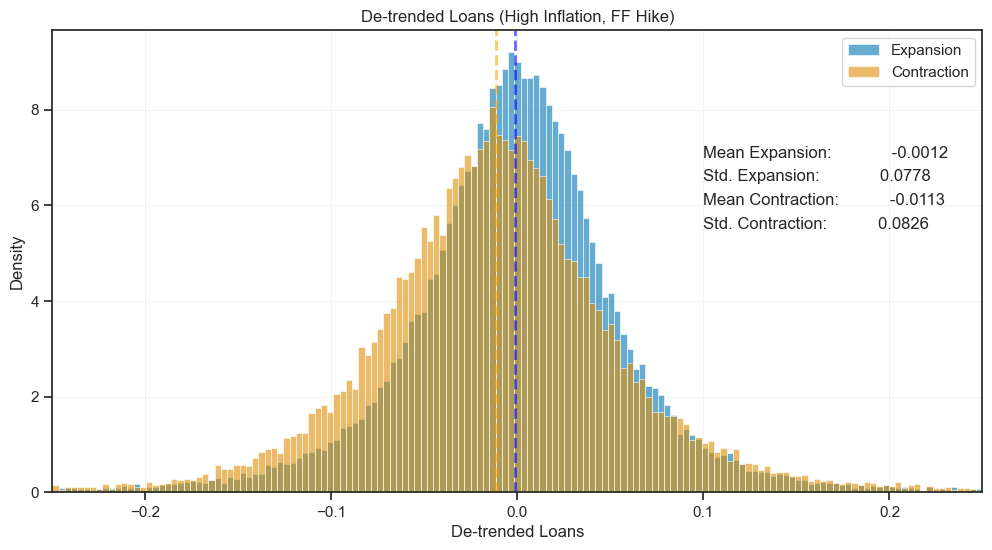

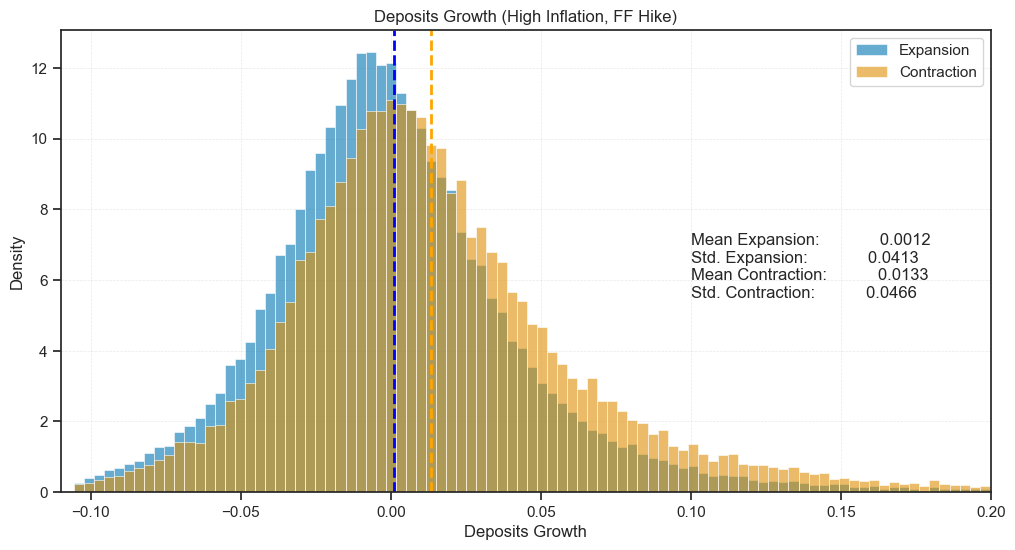

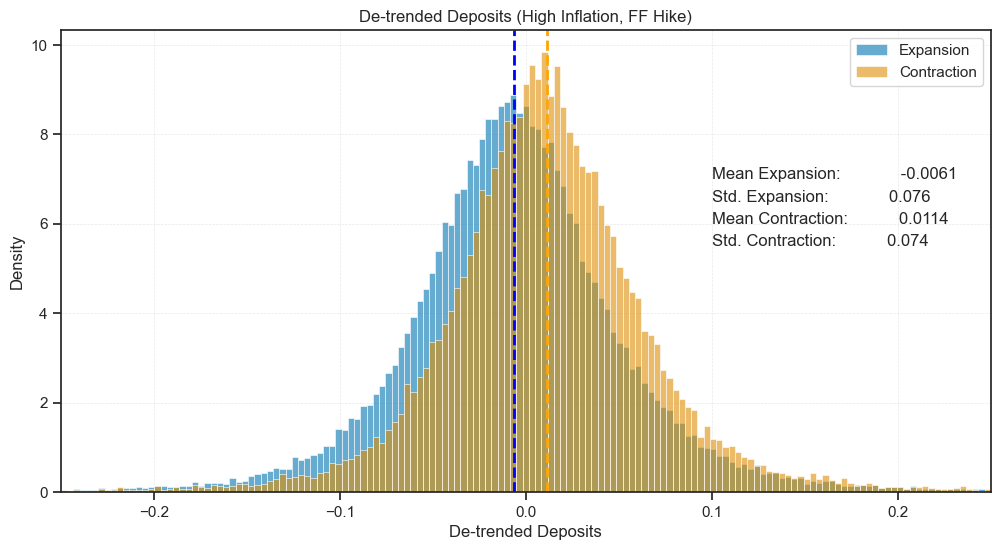

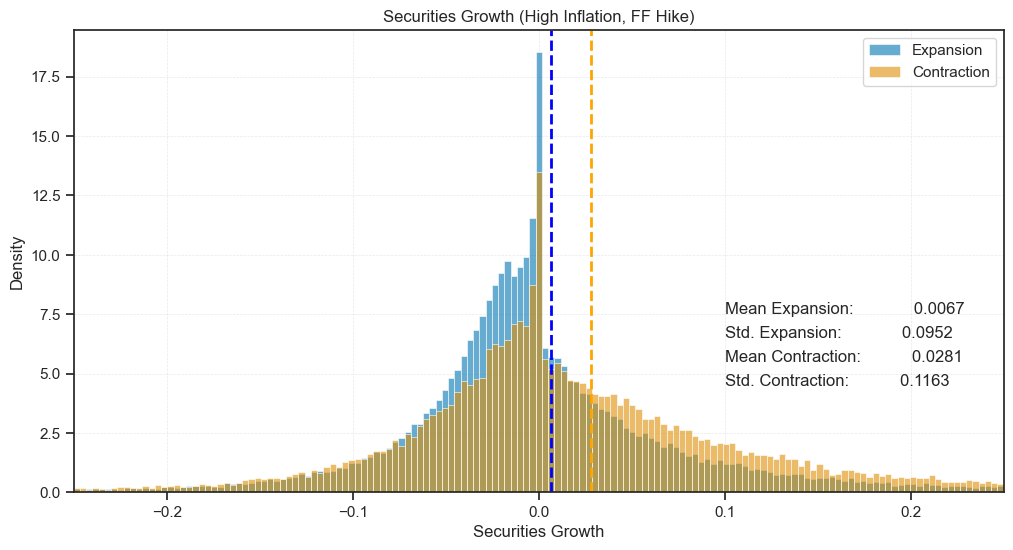

In [142]:
# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
lin = np.linspace(-0.25, 0.25, 150)
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Loans Growth'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Loans Growth'].mean(), color='blue',
            linestyle='--', linewidth=2, alpha=0.6)
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Loans Growth'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
# plot the mean of both distributions:
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Loans Growth'].mean(), color='orange',
            linestyle='--', linewidth=2, alpha=0.6)
plt.title('Growth Rate of Loans (High Inflation, FF Hike)')
plt.xlabel('Growth Rate of Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.12, 0.2)
plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Loans Growth'].mean(), 4)))
plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Loans Growth'].std(), 4)))
plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Loans Growth'].mean(), 4)))
plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Loans Growth'].std(), 4)))
plt.savefig('LoansGrowth_Histogram.png')
plt.show()

plt.figure(figsize=(12, 6))
lin = np.linspace(-0.25, 0.25, 150)
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'].mean(), color='blue',
            linestyle='--', linewidth=2, alpha=0.6)
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
# plot the mean of both distributions:
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'].mean(), color='orange',
            linestyle='--', linewidth=2, alpha=0.6)
plt.title('De-trended Loans (High Inflation, FF Hike)')
plt.xlabel('De-trended Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'].mean(), 4)))
plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'].std(), 4)))
plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'].mean(), 4)))
plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'].std(), 4)))
plt.savefig('Loans_Histogram.png')
plt.show()


# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Deposits Growth'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Deposits Growth'].mean(), linestyle='--', linewidth=2, color='blue')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Deposits Growth'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Deposits Growth'].mean(), linestyle='--', linewidth=2, color='orange')
plt.title('Deposits Growth (High Inflation, FF Hike)')
plt.xlabel('Deposits Growth')
plt.ylabel('Density')
plt.legend()
# print the std deviation of both distributions in the (-0.2,8) coordinate:
plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Deposits Growth'].mean(), 4)))
plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Deposits Growth'].std(), 4)))
plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Deposits Growth'].mean(), 4)))
plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Deposits Growth'].std(), 4)))
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.11, 0.2)
plt.savefig('DepositsGrowth_Histogram.png')
plt.show()

# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Deposits'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Deposits'].mean(), linestyle='--', linewidth=2, color='blue')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Deposits'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Deposits'].mean(), linestyle='--', linewidth=2, color='orange')
plt.title('De-trended Deposits (High Inflation, FF Hike)')
plt.xlabel('De-trended Deposits')
plt.ylabel('Density')
plt.legend()
# print the std deviation of both distributions in the (-0.2,8) coordinate:
plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Deposits'].mean(), 4)))
plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Deposits'].std(), 4)))
plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Deposits'].mean(), 4)))
plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Deposits'].std(), 4)))
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.savefig('Deposits_Histogram.png')
plt.show()

# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Securities Growth'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='blue')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Securities Growth'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='orange')
plt.title('Securities Growth (High Inflation, FF Hike)')
plt.xlabel('Securities Growth')
plt.ylabel('Density')
plt.legend()
# print the std deviation of both distributions in the (-0.2,8) coordinate:
plt.text(0.1, 7.5, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Securities Growth'].mean(), 4)))
plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Securities Growth'].std(), 4)))
plt.text(0.1, 5.5, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Securities Growth'].mean(), 4)))
plt.text(0.1, 4.5, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Securities Growth'].std(), 4)))
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.savefig('Securities_Histogram.png')
plt.show()

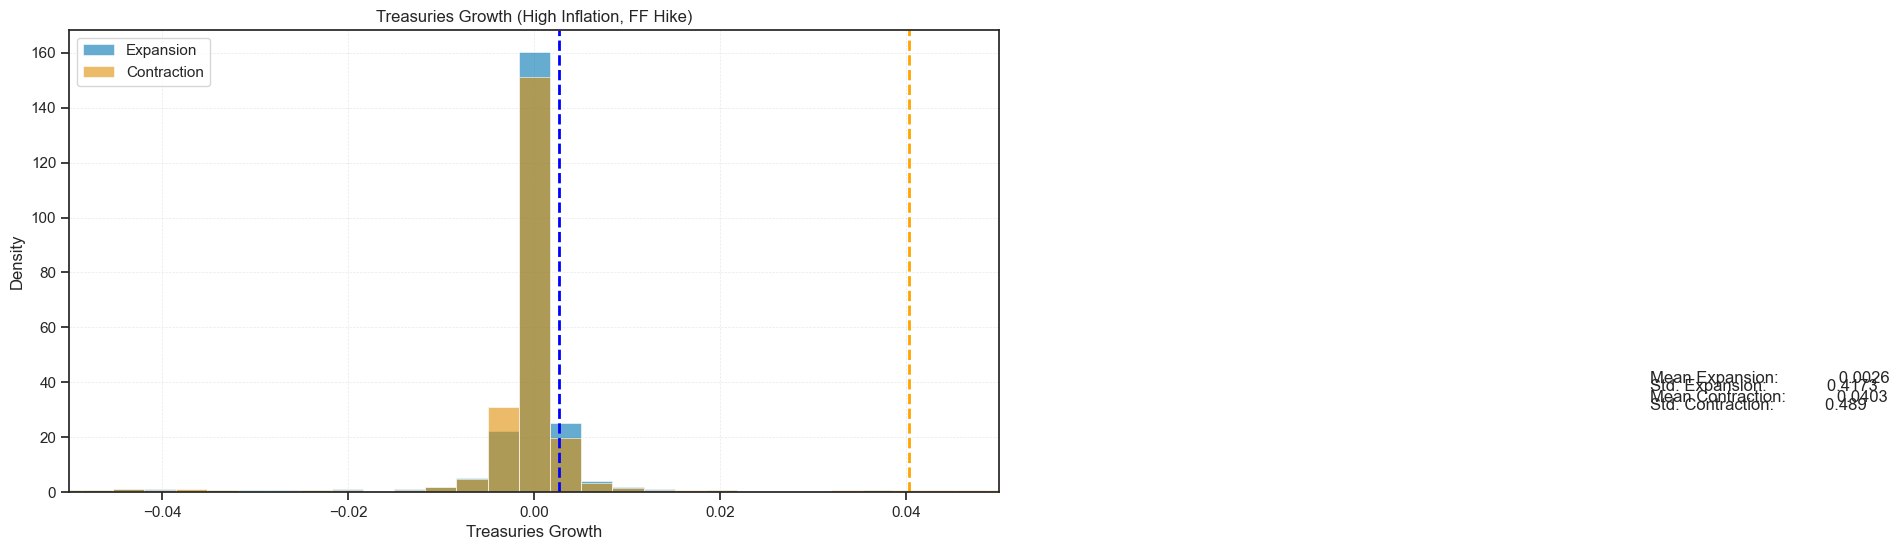

In [119]:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Treasuries Growth'], 
             label='Expansion', bins=lin, stat='density', alpha=0.6)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Treasuries Growth'].mean(), linestyle='--', linewidth=2, color='blue')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Treasuries Growth'], 
             label='Contraction', bins=lin, alpha=0.6, stat='density')
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Treasuries Growth'].mean(), linestyle='--', linewidth=2, color='orange')
plt.title('Treasuries Growth (High Inflation, FF Hike)')
plt.xlabel('Treasuries Growth')
plt.ylabel('Density')
plt.legend()
# print the std deviation of both distributions in the (-0.2,8) coordinate:
plt.text(0.12, 40, 'Mean Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Treasuries Growth'].mean(), 4)))
plt.text(0.12, 37, 'Std. Expansion:             ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['Treasuries Growth'].std(), 4)))
plt.text(0.12, 33, 'Mean Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Treasuries Growth'].mean(), 4)))
plt.text(0.12, 30, 'Std. Contraction:           ' + str(round(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['Treasuries Growth'].std(), 4)))
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.05, 0.05)
plt.savefig('Treasuries_Histogram.png')
plt.show()

In [120]:
# compute the shares of loans, treasuries, and securities as the sum of the three. 
df['Share of Loans'] = df['Agg. Real Loans'] / (df['Agg. Real Loans'] + df['Agg. Treasuries'] + df['Agg. Total Securities']) * 100
df['Share of Treasuries'] = df['Agg. Treasuries'] / (df['Agg. Real Loans'] + df['Agg. Treasuries'] + df['Agg. Total Securities']) * 100
df['Share of Securities'] = df['Agg. Total Securities'] / (df['Agg. Real Loans'] + df['Agg. Treasuries'] + df['Agg. Total Securities']) * 100

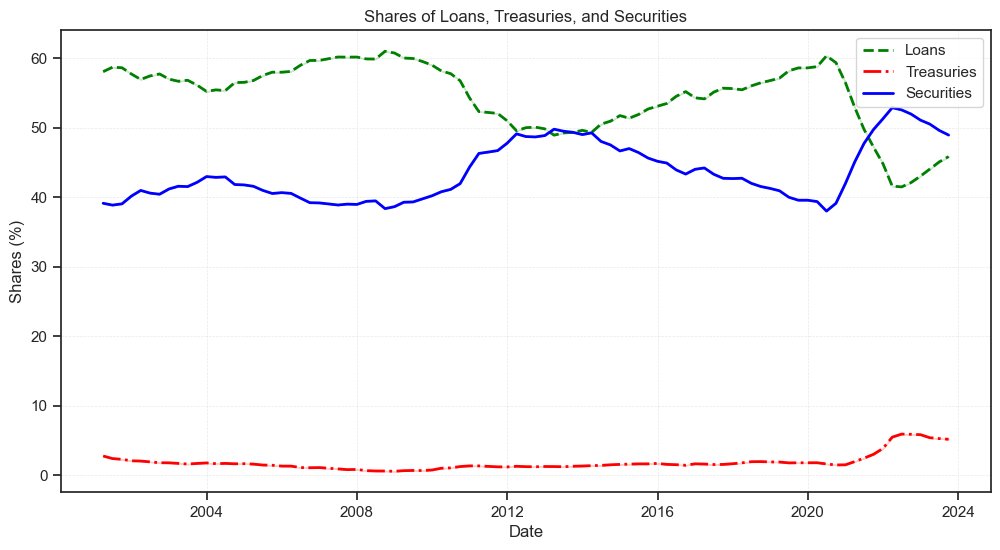

In [121]:
# plot the time series of the shares of loans, treasuries, and securities:
plt.figure(figsize=(12, 6))

sns.lineplot(x='Date', y='Share of Loans', data=df, linewidth=2, label='Loans', color='green', linestyle='--')
sns.lineplot(x='Date', y='Share of Treasuries', data=df, linewidth=2, label='Treasuries', color='red', linestyle='-.')
sns.lineplot(x='Date', y='Share of Securities', data=df, linewidth=2, label='Securities', color='blue')
plt.title('Shares of Loans, Treasuries, and Securities')
plt.xlabel('Date')
plt.ylabel('Shares (%)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [154]:
# Filter conditions for Expansion and Contraction
expansion_condition = (df['Recession'] == 0) & (df['FF Hike'] == 1) & (df['High Inflation'] == 1)
contraction_condition = (df['Recession'] == 1) & (df['FF Hike'] == 1) & (df['High Inflation'] == 1)

# Number of bins
num_bins = 100


# Define function to compute binned averages using qcut
def binned_scatter(x, y, q, label):
    # Create quantile bins using qcut
    x_binned, bin_edges = pd.qcut(x, q=q, retbins=True, duplicates='drop')
    bin_centers = [x[(x_binned == interval)].mean() for interval in x_binned.unique()]
    binned_means = [y[x_binned == interval].mean() for interval in x_binned.unique()]
    
    # Plot the binned means
    plt.scatter(bin_centers, binned_means, label=label, alpha=0.7)

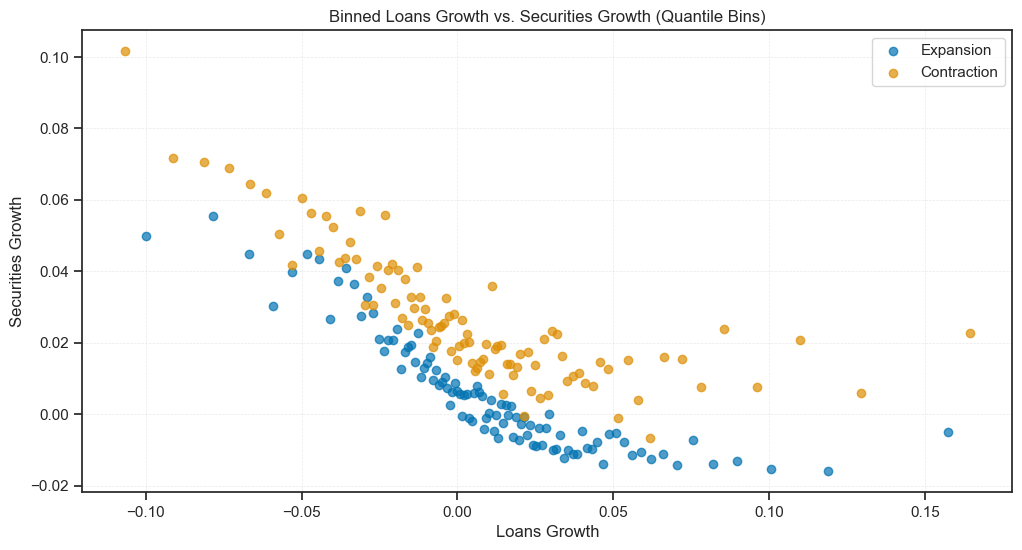

In [155]:
# Create the figure
plt.figure(figsize=(12, 6))

# Number of quantile bins
num_quantiles = 100

# Binned scatter for expansion
binned_scatter(
    df.loc[expansion_condition, 'Loans Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
)

# Binned scatter for contraction
binned_scatter(
    df.loc[contraction_condition, 'Loans Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
)

# Plot settings
plt.title('Binned Loans Growth vs. Securities Growth (Quantile Bins)')
plt.ylabel('Securities Growth')
plt.xlabel('Loans Growth')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('Loans_Securities_Scatter.png')
plt.show()

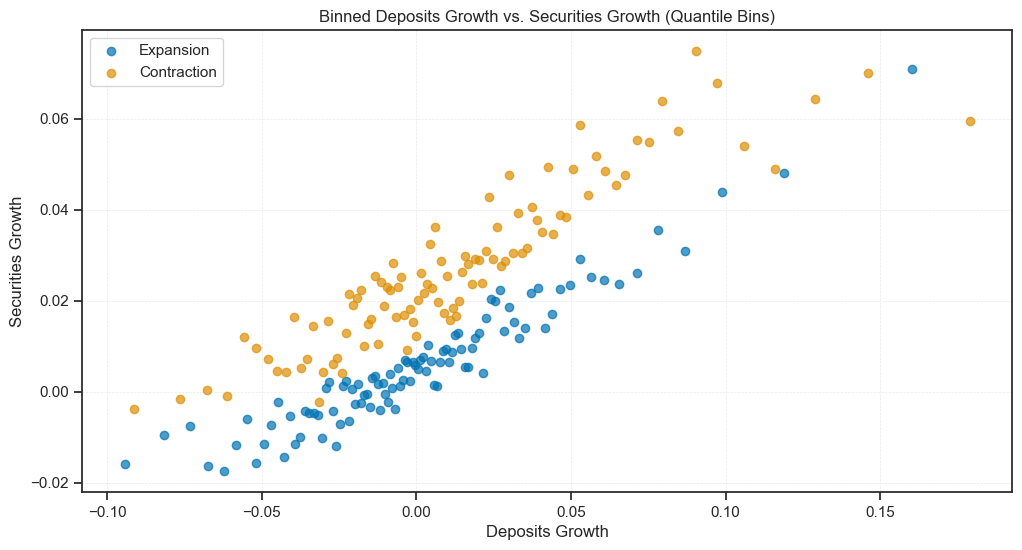

In [156]:
# create a 'positive_deposit_growth_condition':
positive_deposit_growth_condition = df['Deposits Growth'] > 0

# Create the figure
plt.figure(figsize=(12, 6))

# Number of quantile bins
num_quantiles = 100

# Binned scatter for expansion
binned_scatter(
    df.loc[expansion_condition, 'Deposits Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
)

# Binned scatter for contraction
binned_scatter(
    df.loc[contraction_condition, 'Deposits Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
)

# Plot settings
plt.title('Binned Deposits Growth vs. Securities Growth (Quantile Bins)')
plt.ylabel('Securities Growth')
plt.xlabel('Deposits Growth')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('Deposits_Securities_Scatter.png')
plt.show()

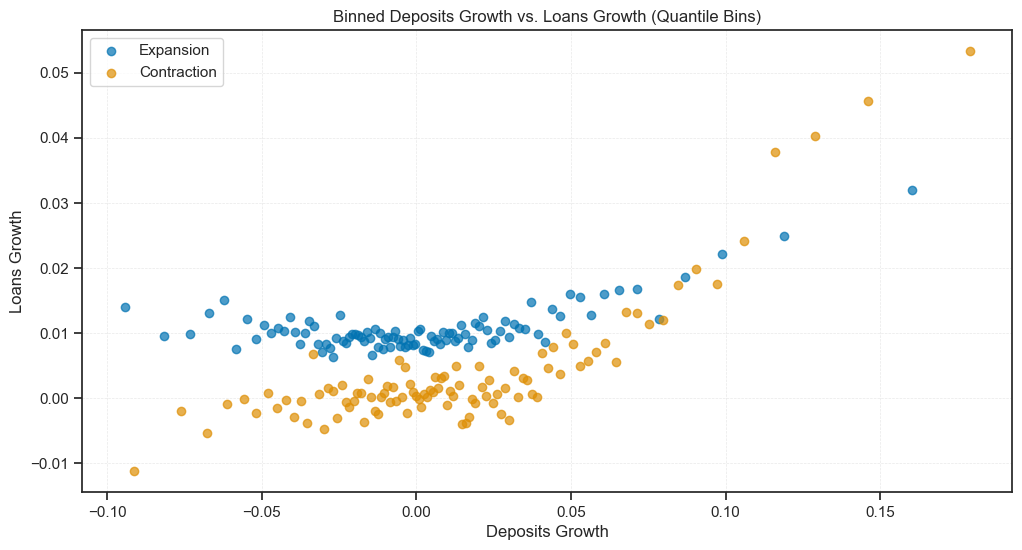

In [158]:
# Create the figure
plt.figure(figsize=(12, 6))

# Number of quantile bins
num_quantiles = 100

# Binned scatter for expansion
binned_scatter(
    df.loc[expansion_condition, 'Deposits Growth'], 
    df.loc[expansion_condition, 'Loans Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
)

# Binned scatter for contraction
binned_scatter(
    df.loc[contraction_condition, 'Deposits Growth'], 
    df.loc[contraction_condition, 'Loans Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
)

# Plot settings
plt.title('Binned Deposits Growth vs. Loans Growth (Quantile Bins)')
plt.ylabel('Loans Growth')
plt.xlabel('Deposits Growth')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('Deposits_Loans_Scatter.png')
plt.show()

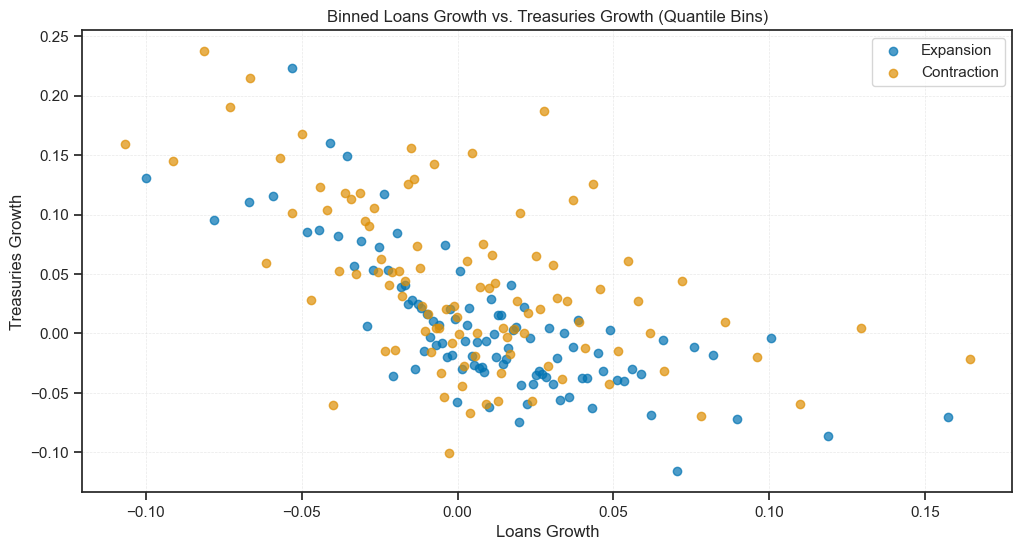

In [159]:
# Create the figure
plt.figure(figsize=(12, 6))

# Number of quantile bins
num_quantiles = 100

# Binned scatter for expansion
binned_scatter(
    df.loc[expansion_condition, 'Loans Growth'], 
    df.loc[expansion_condition, 'Treasuries Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
)

# Binned scatter for contraction
binned_scatter(
    df.loc[contraction_condition, 'Loans Growth'], 
    df.loc[contraction_condition, 'Treasuries Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
)

# Plot settings
plt.title('Binned Loans Growth vs. Treasuries Growth (Quantile Bins)')
plt.ylabel('Treasuries Growth')
plt.xlabel('Loans Growth')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

Apparently, there is a mass of banks that lose loans during a _supply shock_ (histogram). This mass of banks appears to coincide with the banks that loose deposits (scatter). Our claim is that those banks are more exposed to hikes in interest rates. 

In [127]:
# compute the correlation between de-trended loans and de-trended deposits in the boom and recession periods:
print('Correlation between loans and deposits in booms:     ', df[(df['Recession']==0) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Loans'].corr(df[(df['Recession']==0) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Deposits']))
print('Correlation between loans and deposits in recessions:', df[(df['Recession']==1) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Loans'].corr(df[(df['Recession']==1) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Deposits']))

Correlation between loans and deposits in booms:      0.5012165002696031
Correlation between loans and deposits in recessions: 0.46296111307360505


In [128]:
def compute_deposit_growth(df, transformations, window=1):
    """
    Compute the log difference of deposits while accounting for mergers, acquisitions, and failures.

    Args:
    - df (pd.DataFrame): Dataframe containing bank-level balance sheet data.
    - transformations (pd.DataFrame): Dataframe containing information about transformations.
    - window (int): Number of quarters before and after a transaction to set as NaN for growth rate.

    Returns:
    - pd.DataFrame: The updated 'df' with a 'deposit_growth' column.
    """
    # Sort the dataframe by bank ID and date to ensure proper lag calculation
    df = df.sort_values(by=['IDRSSD', 'Date'])
    
    # Calculate log difference (log growth rate) of deposits
    df['Real Deposit Growth'] = df.groupby('IDRSSD')['Real Deposits'].transform(lambda x: np.log(x).diff())   
    
    # Create a mask to identify rows to be set to NaN
    for _, row in transformations.iterrows():
        predecessor_id = row['Predecessor ID']
        successor_id = row['Successor ID']
        transaction_date = row['Transaction Date']
        
        # Identify date range around the transaction
        start_date = transaction_date - pd.DateOffset(months=3 * window)
        end_date = transaction_date + pd.DateOffset(months=3 * window)
        
        # Apply NaN to the specified window for predecessor and successor banks
        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Real Deposit Growth'
        ] = np.nan
    
    return df

In [129]:
df = compute_deposit_growth(df, transformations, window=1)

KeyboardInterrupt: 

In [59]:
# trim dataset in the top and bottom 1%:
#df = df[(df['Real Deposit Growth'] > df['Real Deposit Growth'].quantile(0.01)) & (df['Real Deposit Growth'] < df['Real Deposit Growth'].quantile(0.99))]

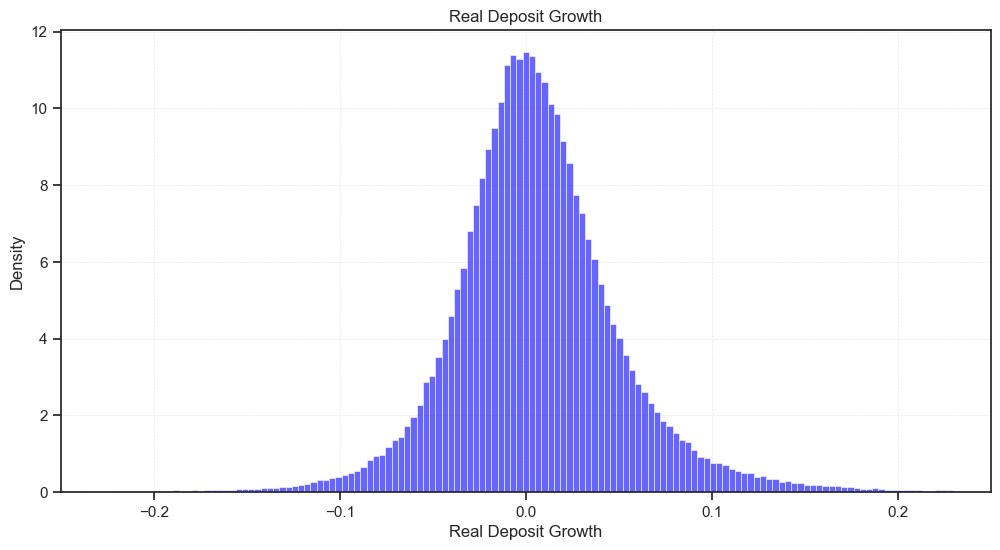

In [60]:
# plot the histogram of the deposit growth:
bins = np.linspace(-0.25, 0.25, 150)
plt.figure(figsize=(12, 6))
sns.histplot(df['Real Deposit Growth'], color='blue', alpha=0.6, stat='density', bins=bins)
plt.xlim(-0.25,0.25)
plt.title('Real Deposit Growth')
plt.xlabel('Real Deposit Growth')
plt.ylabel('Density')
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')

In [61]:
predecessor_id=802866

In [62]:
# Filter the specific transformation row for the given predecessor_id
transformation_row = transformations[transformations['Predecessor ID'] == predecessor_id]

In [63]:
transaction_date = transformation_row['Transaction Date'].iloc[0]
successor_id = transformation_row['Successor ID'].iloc[0]

In [64]:
# Exclude the predecessor and successor banks
excluded_banks = {predecessor_id, successor_id}
df_filtered = df[~df['IDRSSD'].isin(excluded_banks)]

In [65]:
# what is the closest date to the 'transaction_date' in 'df_filtered':
closest_date = df_filtered['Date'].iloc[(df_filtered['Date'] - transaction_date).abs().argsort()[:1]].values[0]
print('Closest date to the transaction date:', pd.to_datetime(closest_date, format='%Y%m%d'))

Closest date to the transaction date: 2023-03-31 00:00:00


In [66]:
df_after_transaction = df_filtered[df_filtered['Date'] == closest_date]

In [67]:
print('The banks that had POSITIVE growth rate of deposits after SVB, had an avg. share of deposits:', 
      df_after_transaction[df_after_transaction['Real Deposit Growth']>0]['Share Real Loans'].mean())
print('The banks that had NEGATIVE growth rate of deposits after SVB, had an avg. share of deposits:', 
      df_after_transaction[df_after_transaction['Real Deposit Growth']<0]['Share Real Loans'].mean())

The banks that had POSITIVE growth rate of deposits after SVB, had an avg. share of deposits: 0.04334662914707553
The banks that had NEGATIVE growth rate of deposits after SVB, had an avg. share of deposits: 0.0446293738365986
